In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import networkx as nx
from scipy.special import softmax
from tqdm import tqdm
from random import shuffle
import copy
from collections import defaultdict
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from uga import UGA
from trm import TRM
from lp import LP

In [2]:
data = pd.read_csv('nyc_citi.csv')
data = data.loc[[type(i)==str for i in data['start station name']]]
data = data.loc[[type(i)==str for i in data['end station name']]]
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [3]:
data.starttime=data.starttime.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data.stoptime=data.stoptime.apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
print(data.shape)

(559644, 15)


In [4]:
def build_station_graph(data,starttime,stoptime):
    graphx=nx.Graph()
    filtered_data = data[(data['starttime']>=starttime) & (data['stoptime']<=stoptime)]
    locations = list(set(filtered_data['start station name']).union(filtered_data['end station name']))
    vertices = pd.Series([{}]*len(locations),index=locations)
    for loc in locations:
        vertices[loc] = {'change':0,'x':np.random.random(),'y':np.random.random(),'type':''}
        
    for i in filtered_data['start station name']:
        vertices[i]['change'] -= 1
    for i in filtered_data['end station name']:
        vertices[i]['change'] += 1
    for loc in locations:
        if vertices[loc]['change'] > 0:
            vertices[loc]['type'] = 'overflow'
        if vertices[loc]['change'] < 0:
            vertices[loc]['type'] = 'underflow'
    vertices = vertices.loc[[x['type'] != '' for x in vertices]]
    for vertex in vertices.index:
        graphx.add_node(vertex,bipartite=int(vertices[vertex]['type']=='overflow'))
    #print(vertices)
    nx.set_node_attributes(graphx, {i: vertices[i] for i in vertices.index}) 
    for i in range(len(vertices.index)):
        for j in range(len(vertices.index)):
            if vertices[vertices.index[i]]['type'] != vertices[vertices.index[j]]['type'] and not graphx.has_edge(i,j):
                x1=vertices[vertices.index[i]]['x']
                y1=vertices[vertices.index[i]]['y']
                x2=vertices[vertices.index[j]]['x']
                y2=vertices[vertices.index[j]]['y']
                graphx.add_weighted_edges_from([(vertices.index[i],vertices.index[j],euc_dis(x1,y1,x2,y2))])
    return graphx

def cloned_station_vertices(graphx):
    nodes = list(graphx.nodes())
    for node in nodes:
        if graphx.nodes[node]['change']>1:
            for i in range(graphx.nodes[node]['change']-1):
                i = i+1
                graphx.add_nodes_from([(str(node)+str(i),graphx.nodes[node])],bipartite=int(graphx.nodes[node]['bipartite']))
                new_node_name = str(node)+str(i)
                new_node_data = graphx.nodes[new_node_name]
                for node_ in graphx.nodes:
                    if new_node_data['bipartite'] != graphx.nodes[node_]['bipartite']:
                        x1=new_node_data['x']
                        y1=new_node_data['y']
                        x2=graphx.nodes[node_]['x']
                        y2=graphx.nodes[node_]['y']
                        graphx.add_weighted_edges_from([(node_,new_node_name,euc_dis(x1,y1,x2,y2))])
    return graphx
                
def draw_bipartite(B):
    l, r = nx.bipartite.sets(B)
    pos = {}

    # Update position for node from each group
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))

    nx.draw(B, pos=pos)
    plt.show()
def draw_graph(B):
    pos = {}

    # Update position for node from each group
    pos.update((node, (B.nodes[node]['x'], B.nodes[node]['y'])) for node in list(B.nodes))
    nx.draw(B, pos=pos)
    plt.show()
                
            

['Greenwich St & W Houston St', 'E 7 St & Avenue A', 'Washington Square E', 'E 4 St & 2 Ave', 'Madison St & Clinton St', 'Catherine St & Monroe St', '9 Ave & W 14 St', 'Hancock St & Bedford Ave', 'W 20 St & 11 Ave', 'Lispenard St & Broadway', 'E 10 St & 5 Ave', 'E 6 St & Avenue B', 'W 45 St & 6 Ave (1)', '1 Ave & E 16 St', 'Ashland Pl & Hanson Pl', 'Murray St & West St', 'Pearl St & Anchorage Pl', 'W 37 St & 10 Ave', 'Mercer St & Spring St', 'Washington Park', 'DeKalb Ave & S Portland Ave', '8 Ave & W 33 St', 'NYCBS Depot - DEL', '2 Ave & E 31 St', 'Pershing Square North', 'W 33 St & 7 Ave', 'E 31 St & 3 Ave', 'Atlantic Ave & Fort Greene Pl', 'Harrison St & Hudson St', 'W 51 St & 6 Ave', 'Broadway & W 51 St', 'Stanton St & Chrystie St', 'Fulton St & Grand Ave', 'Hicks St & Montague St', '8 Ave & W 31 St N', 'Rivington St & Chrystie St', 'E 52 St & 2 Ave', 'Pershing Square South', 'W 22 St & 10 Ave', 'State St & Smith St', 'E 5 St & Avenue C', 'W 15 St & 7 Ave', 'West St & Chambers St',

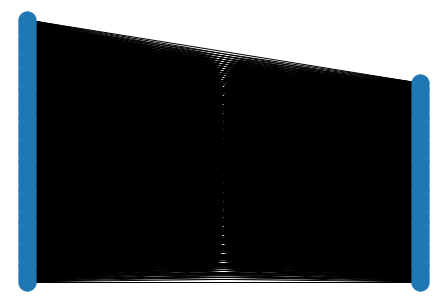

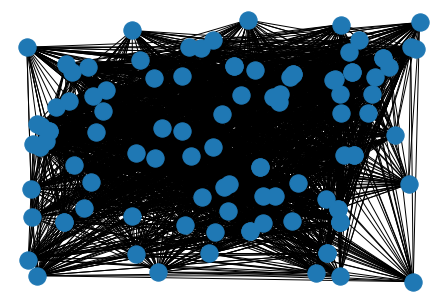

In [5]:
def euc_dis(x1,y1,x2,y2):
        return ((x1-x2)**2+(y1-y2)**2)**.5
graph = build_station_graph(data,data.loc[0,'starttime'],data.loc[100,'stoptime'])
#print(graph['E 6 St & Avenue D'])
overflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='overflow'}
underflow = {node:{} for node in graph.nodes() if graph.nodes[node]['type']=='underflow'}


cgraph = cloned_station_vertices(graph)
workers = {i:{
                'type':'worker',
               'xs':np.random.random(),
               'ys':np.random.random(),
               'xe':np.random.random(),
               'ye':np.random.random()
              } for i in range(np.min([len(underflow), len(overflow)]))}
cwgraph = copy.deepcopy(cgraph)
print(cwgraph.nodes)
cwgraph.add_nodes_from(range(len(workers)))
nx.set_node_attributes(cwgraph, workers) 
cwgraph.add_edges_from([(w,s) for w in workers for s in cgraph.nodes])
worker = {node:{} for node in cwgraph.nodes() if cwgraph.nodes[node]['type']=='worker'}
print(cwgraph.nodes)
print(cwgraph.nodes[1])
draw_bipartite(cgraph)
draw_graph(cgraph)

In [6]:
uga = UGA(cwgraph)
#best, score, log = uga.run(0.1,0.1,400,200)
#plt.plot(log)
#plt.show()

In [7]:
trm = TRM()
trm.solve(cgraph,cwgraph,worker)[-1]

59.05550222823474

In [25]:
def euc_dis(x1,y1,x2,y2):
        return ((x1-x2)**2+(y1-y2)**2)**.5
def edge_cost(edge, cwgraph):
    return euc_dis(cwgraph.nodes[edge[2]]['x'], cwgraph.nodes[edge[2]]['y'], cwgraph.nodes[edge[0]]['xe'], cwgraph.nodes[edge[0]]['ye']) + euc_dis(cwgraph.nodes[edge[1]]['x'], cwgraph.nodes[edge[1]]['y'], cwgraph.nodes[edge[2]]['x'], cwgraph.nodes[edge[2]]['y']) + euc_dis(cwgraph.nodes[edge[1]]['x'], cwgraph.nodes[edge[1]]['y'], cwgraph.nodes[edge[0]]['xs'], cwgraph.nodes[edge[0]]['ys'])

def total_cost(matching, cwgraph):
    return sum([edge_cost(edge,cwgraph) for edge in matching])

def neighborhood_weight(edge, possible_edges, weights):
    return sum([x[edge_].value() for edge_ in possible_edges if len(set(edge).intersection(set(edge_)))>0])

def local_ratio(F,w):
    F = [edge for edge in F if w[str(edge)] > 0]
    
    print(len(F))
    if len(F) == 0:
        return F
    edge = F[0]
    
    w1 = {str(edge_):(w[str(edge_)] if len(set(edge).intersection(set(edge_)))>0 else 0) for edge_ in F }
    w2 = {str(edge_):w[str(edge_)]-w1[str(edge_)] for edge_ in F}
    m = local_ratio(F,w2)
    m_ = set(m).union({edge})
    for e1 in list(m_):
       for e2 in list(m_):
           if e1 != e2 and len(set(e1).intersection(set(e2))) > 0:
               return m
    return m_

def matching_to_graph(matching,cwgraph):
    G = nx.Graph()
    for w,o,u in matching:
        G.add_node(w,**(cwgraph.nodes[w]))
        G.add_node(o,**(cwgraph.nodes[o]))
        G.add_node(u,**(cwgraph.nodes[u]))
        G.add_edge(w,u)
        G.add_edge(w,o)
        G.add_edge(u,o)
    return G

In [13]:
lp_ = LP()
m,s =lp_.solve(cwgraph,worker,overflow,underflow)
s

Status: Optimal


29.35457203491225

{'bipartite': 1, 'change': 2, 'x': 0.8255604556266601, 'y': 0.802517583601639, 'type': 'overflow'}


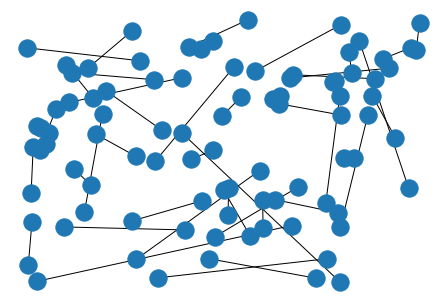

In [26]:

g=matching_to_graph(m,cwgraph)
for node in list(g.nodes):
    if g.nodes[node]['type']=='worker':
        g.remove_node(node)
print(g.nodes[list(g.nodes)[0]])
draw_graph(g)



In [29]:
import pulp

#define arrangements
possible_edges= [(w,o,u) for w in worker for o in overflow for u in underflow]

#make problem 
wap_model = pulp.LpProblem("WAP_Model", pulp.LpMaximize)

#make dict of them with bounds for fractional assignments
x = pulp.LpVariable.dicts(
    "edge_fractions", possible_edges, lowBound=0
)
lc = 1000
#create objective function
wap_model += pulp.lpSum([x[edge]*(lc-edge_cost(edge,cwgraph)) for edge in possible_edges])

#contrain weights to sum to 1
for vertex in list(cwgraph.nodes):
    wap_model += (
        pulp.lpSum([x[edge] for edge in possible_edges if vertex in edge]) <= 1,
        "assignment_bound_%s" % str(vertex),
    )
wap_model.solve()

non_zero = [edge for edge in possible_edges if x[edge].value() > 0]
f = []
possible_edges_ = sorted(copy.deepcopy(possible_edges), key=lambda e: neighborhood_weight(e,non_zero,x))


for e in tqdm(range(len(possible_edges_))):
    i = 0
    edge = possible_edges_[i]
    while neighborhood_weight(edge,non_zero,x) > 2:
        #print(neighborhood_weight(edge,non_zero,x))
        i+=1
        edge = possible_edges_[i]
        #print(edge)
    possible_edges_.pop(i)
    if edge in non_zero:
        non_zero.remove(edge)
    f.append(edge)
w_dict = {str(edge):x[edge].value() for edge in possible_edges}
print('starting ratio')
print(str(w_dict)[:300])

total_cost(local_ratio(f,w_dict),cwgraph)

100%|██████████| 93150/93150 [00:01<00:00, 87623.24it/s]
starting ratio
{"(0, 'Greenwich St & W Houston St', 'E 4 St & 2 Ave')": 0.0, "(0, 'Greenwich St & W Houston St', '9 Ave & W 14 St')": 0.0, "(0, 'Greenwich St & W Houston St', 'Lispenard St & Broadway')": 0.0, "(0, 'Greenwich St & W Houston St', 'W 45 St & 6 Ave (1)')": 0.0, "(0, 'Greenwich St & W Houston St', 'Ash
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


29.354572034912252